In [1]:
import torch
import math
#torch.set_grad_enabled(False)

In [2]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [3]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [4]:
class Optimizers(object):
    # this is a SGD optimizer
    def __init__(self,lr,max_iter, parameters, momentum = True ,beta= 0.9) :  # should we add a "tolerance_grad" argument ? 
        super().__init__()
        self.eta = lr
        self.maxStep = max_iter # maybe this shouldn't be put inside the module
        self.param = parameters
        self.number_step = 0
        # initialize momentum to zero
        self.v = self.param.copy()
        self.v = []
        for i in range(len(self.param)):
            size_param = self.param[i].data.size()
            v_init= torch.zeros(size_param)
            (self.v).append(v_init)
        self.beta = beta
        self.momentum = momentum

    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0

    def step(self): #batch de datapoint  --> confused : how can we do it stochastic ? ou alors on l'appelle step(batch)
        # right now, eta is considered constant 
        #print(self.param[1].data)
        #print('step')
        if self.number_step <=self.maxStep:
            #for parameter in self.param :
            for parameter, V in zip(self.param, self.v):
                #print(V)
                if self.momentum :
                    V = self.beta * V + self.eta * parameter.grad    # is it only for weight or also bias 
                    parameter.data = parameter.data - V
                else : 
                    parameter.data = parameter.data - self.eta * parameter.grad
           
            self.number_step = self.number_step + 1
            #print('after update',self.param[1].data)
        return self.param
    def momentum(self):
        for parameter, V in zip(self.params, self.v):
           V = self.beta * V + self.eta * parameter.grad    # is it only for weight or also bias 
           parameter = parameter - V


In [5]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [6]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        return self.weight.data.mv(x) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(-1, 1)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        self.weight.grad += prev_grad.view(-1, 1)*self.x.view(1, -1)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            self.bias.grad += prev_grad.view(-1)
        
        next_grad = prev_grad.view(1, -1)@self.weight.data
        next_grad = next_grad.view(-1, 1)
        return next_grad
    
    def get_parameters(self):
        return self.parameters
    

In [7]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
    

In [8]:
class MSE(Losses):
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/len(self.x)

In [9]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
  
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
#    def backward(self,weights,values,dl_dw,target):
#        xn=values[-1]
#        dl_dx=[]
#        dl_dx.append(dloss(x_n,t))
#        for i in range(len(self.modules)).reversed():
#            m=self.modules[i]
#            dl_dx.append(m.backwardoutput(dl_dx[-1],values[i]))#backward is implemented for each module
#        for i in range(len(self.modules)).reversed():
#            m=self.modules[i]
#            dl_dw=m.backwardweights(dl_dw,dl_dx[i+1],values[i])
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        #print(self.parameters[1].data)
        self.parameters = params
        #print('after',self.parameters[1].data)
        #for i in range (len(new_par)):
         #   self.parameters[i] = params[i]

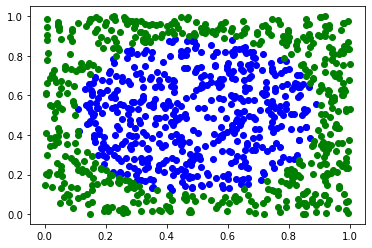

In [10]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0, 1)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
input_data, output_data=generate_disc_set(1000)
output_data=1-output_data
import matplotlib.pyplot as plt
plt.plot(input_data[:,0][output_data==1],input_data[:,1][output_data==1],'bo')
plt.plot(input_data[:,0][output_data!=1],input_data[:,1][output_data!=1],'go')

In [11]:
input_data-=input_data.mean(0)
input_data/=input_data.std(0)
print(input_data)


tensor([[ 0.3707,  1.0812],
        [-0.7487,  1.5427],
        [ 1.5179,  0.7199],
        ...,
        [-1.1990, -0.8590],
        [ 1.5056,  1.3492],
        [-0.0707,  1.2786]])


In [12]:
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma,
    linear2,
    sigma,
    linear3,
    sigma,
])

In [13]:
optimizer = Optimizers(lr = 1e-4,max_iter = 100, parameters = net.get_parameters(), momentum = True)
#n=10**3
n = 250
N=output_data.shape[0]
for t in range(n):
    acc_loss=0
    optimizer.zero_grad()

    for i in range(N):
        
        x=input_data[i]
        y=2*output_data[i]-1
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x)

        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

   # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
   #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  1069.170654296875
10    MSE loss =  962.2885131835938
20    MSE loss =  930.8030395507812
30    MSE loss =  899.30615234375
40    MSE loss =  867.3668212890625
50    MSE loss =  835.446533203125
60    MSE loss =  804.4644775390625
70    MSE loss =  775.5711669921875
80    MSE loss =  749.7652587890625
90    MSE loss =  727.4848022460938
100    MSE loss =  708.3740234375
110    MSE loss =  706.5955810546875
120    MSE loss =  706.5955810546875
130    MSE loss =  706.5955810546875
140    MSE loss =  706.5955810546875
150    MSE loss =  706.5955810546875
160    MSE loss =  706.5955810546875
170    MSE loss =  706.5955810546875
180    MSE loss =  706.5955810546875
190    MSE loss =  706.5955810546875
200    MSE loss =  706.5955810546875
210    MSE loss =  706.5955810546875
220    MSE loss =  706.5955810546875
230    MSE loss =  706.5955810546875
240    MSE loss =  706.5955810546875


In [14]:
correct_count=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

Correct predictions after 250 training steps: 93.0 %
